In [1]:
%%HTML

<link rel="stylesheet" href="rise.css"/>

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import numpy as np
from simpeg.electromagnetics import time_domain as tdem
import discretize
from simpeg.utils.solver_utils import get_default_solver
from geoana.em.tdem import simple_functions
from ipywidgets import interact, IntSlider
from IPython.display import display

plt.rcParams['figure.figsize'] = [6.4, 4.2]

In [3]:
h_r = [(5., 2), (1, 16, -1.1), (1,16,1.1), (5., 50, 1.2)]
h_z = [(5., 25, -1.2), (1, 16, -1.1),(1, 16, 1.1), (5., 25, 1.2)]
mesh = discretize.CylindricalMesh([h_r, 1, h_z], origin=[0, 0, 'C'])

sigma = np.ones(len(mesh))
sigma[mesh.cell_centers[:,-1] > 0] = 1E-12

source = tdem.sources.CircularLoop(location=[0, 0, 0], radius=51, waveform=tdem.sources.StepOffWaveform())
srv = tdem.Survey(source)

time_steps = [
    (1E-6, 40, 1.2)
]

sim = tdem.Simulation3DMagneticFluxDensity(mesh, survey=srv, time_steps=time_steps, sigma=sigma, solver=get_default_solver())

field = sim.fields(None)

/opt/anaconda3/envs/simulation/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


In [4]:
class JBPlotter():

    def __init__(self, mesh, j, b, range_x, range_z, stream_nx=256, steam_nz=256, show=False):

        h_r, _, h_z = mesh.h
        h_x = np.r_[h_r[::-1], h_r]
    
        self.mesh_tens = discretize.TensorMesh([h_x, h_z], origin=['C', mesh.origin[-1]])

        j = j.reshape((*mesh.shape_edges_y, -1), order='F').squeeze()
        nt = j.shape[-1]
    
        # build up the whole thing...
        j_left = j[::-1]
        j_middle = np.zeros((1, *j.shape[1:]))
        j_right = j
    
        j = np.concatenate([-j_left, j_middle, j_right], axis=0).reshape((-1, nt), order='F')
        j = self.mesh_tens.average_node_to_cell @ j
        j[self.mesh_tens.cell_centers[:, -1]>=0, :] = np.nan

        self.j = j

        br, bz = b[:mesh.n_faces_x], b[mesh.n_faces_x:]
        br = br.reshape((*mesh.shape_faces_x, -1), order='F').squeeze()
        bz = bz.reshape((*mesh.shape_faces_z, -1), order='F').squeeze()
    
        bx = np.concatenate([-br[::-1], np.zeros((1, *br.shape[1:])), br], axis=0).reshape((-1, nt), order='F')
        bz = np.concatenate([bz[::-1], bz], axis=0).reshape((-1, nt), order='F')
        b = np.concatenate([bx, bz], axis=0)
        b_ccv = self.mesh_tens.average_face_to_cell_vector @ b
        bx, bz = b_ccv.reshape((2, -1, nt))

        self.range_x = range_x
        self.range_z = range_z
    
        nodes_x = np.linspace(*range_x, stream_nx+1)
        nodes_z = np.linspace(*range_z, steam_nz+1)
        hx = nodes_x[1:] - nodes_x[:-1]
        hz = nodes_z[1:] - nodes_z[:-1]
    
        self.stream_mesh = discretize.TensorMesh([hx, hz], [nodes_x[0], nodes_z[0]])
        stream_interp_mat = self.mesh_tens.get_interpolation_matrix(self.stream_mesh.cell_centers, 'cell_centers')

        self.bx = (stream_interp_mat @ bx).reshape((*self.stream_mesh.shape_cells, -1), order='F')
        self.bz = (stream_interp_mat @ bz).reshape((*self.stream_mesh.shape_cells, -1), order='F')

        if show:
            self.do_plot(0)

    def do_plot(self, time_index):

        j = self.j[:, time_index]
        bx = self.bx[..., time_index].T
        bz = self.bz[..., time_index].T

        fig = plt.figure(dpi=300)
        ax = plt.gca()

        #self._frame = display(fig, display_id=True)
    
        vmin = np.nanmin(j)
        vmax = np.nanmax(j)
        thresh = (vmax - vmin) * 0.5

        norm = SymLogNorm(thresh, vmin=vmin, vmax=vmax)

        j_im, = self.mesh_tens.plot_image(
            j, v_type='CC', ax=ax, range_x=self.range_x, range_y=self.range_z,
            pcolor_opts={'norm':norm}
        )
        plt.colorbar(j_im, format=lambda x, _: f"{x:.2E}")

        ax.set_title(rf'Time: {sim.times[time_index]*1E6:.3E} $\mu$s')
        ax.set_ylabel('z')
        ax.axhline(0, color='k')

        s_mesh = self.stream_mesh
        s_plot = ax.streamplot(s_mesh.cell_centers_x, s_mesh.cell_centers_y, bx, bz, color='w')
        plt.show()

plotter = JBPlotter(mesh, field[source, "j"], field[source, "b"], [-200, 200], [-300, 10])

# Time Domain EM (TDEM/TEM) Fundamentals and Instrumentation

Topics
* EM theory applied to the time domain EM experiment
* Collecting TDEM data

## TDEM Physics


Consider a loop of wire laying on the Earth's surface with a **constant** current running through it.

<div class='row'>
<div class='column'>

* Electrical current creates a magnetic field.
* Stength of the field depends on the current and size of the loop (it's magnetic moment).
</div>
<div class='column'>

![ProTEM](resources/2-tx-example.png "ProTEM HF3D Rx")
</div>
</div>



What happens when we turn off the current?!

> **Remember**
>
> Nature wants to preserve magnetic fields!

**Induction!**

In [5]:
interact(plotter.do_plot, time_index=IntSlider(1, 1, 40));

interactive(children=(IntSlider(value=1, description='time_index', max=40, min=1), Output()), _dom_classes=('w…

* At the **instant** the current is turned off:
    * An image of the wire's current is in the subsurface s.t. the $B$-field is the same.
* It then decays downward and outwards
    * Energy disipates due to ohmic heat loss (Diffusion!)
    * Smoke rings

#### B-field at the center
* At the center of the loop, the $B$ field is the strongest.
* If earth is 1D there will only be a z-component of $B$

In [6]:
%%capture b_img
ts = np.logspace(-8,-2)
#ts = np.linspace(0, 0.001, 256)

bz2 = simple_functions.vertical_magnetic_flux_horizontal_loop(ts, sigma=0.1)
plt.plot(ts, bz2, label=r'$\sigma=0.1$')

bz1 = simple_functions.vertical_magnetic_flux_horizontal_loop(ts, sigma=1)
plt.plot(ts, bz1, label=r'$\sigma=1$')

bz3 = simple_functions.vertical_magnetic_flux_horizontal_loop(ts, sigma=10)
plt.plot(ts, bz3, label=r'$\sigma=10$')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('B-field (T)')
plt.title('Magnetic flux density at the center of the transmitter loop')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

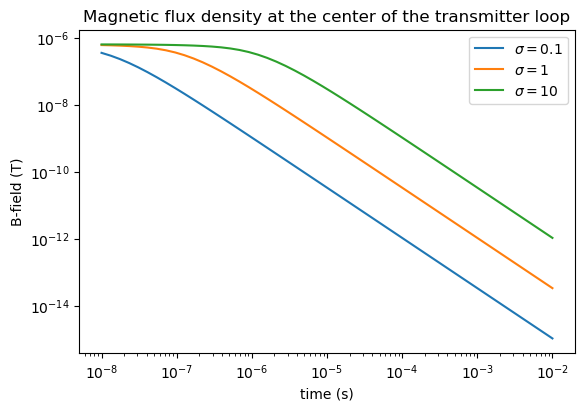

In [7]:
b_img.outputs[0]

In a stronger resistor
* B-Field decreases faster at the start.
* B-Field is smaller.

In [8]:
%%capture db_img
bz2 = simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(ts, sigma=0.1)
plt.plot(ts, -bz2, label=r'$\sigma=0.1$')

bz1 = simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(ts, sigma=1)
plt.plot(ts, -bz1, label=r'$\sigma=1$')

bz3 = simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(ts, sigma=10)
plt.plot(ts, -bz3, label=r'$\sigma=10$')

plt.xlabel('time (s)')
plt.ylabel('-dB/dt (T/s)')
plt.title('Magnetic flux density time derivative at the center of the transmitter loop')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
plt.show()

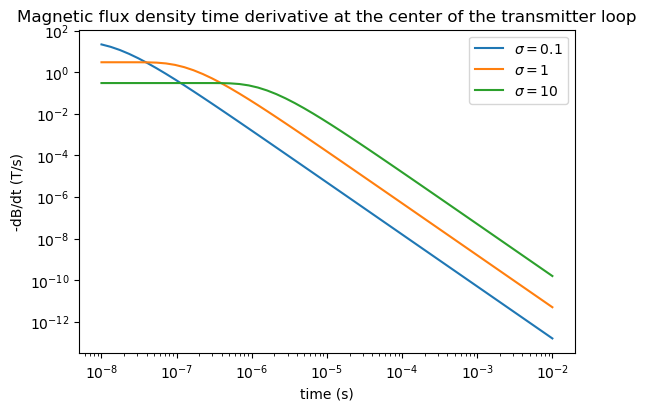

In [9]:
db_img.outputs[0]

In a stronger resistor, since the B-field decreases faster at the start
* dBdT is larger at early times in resistors
* dBdT is larger at late times for conductors

# TDEM Survey Design

All TDEM instruments work off of the same principles:
* Transmitter waveform is abruptly terminated
* Receiver(s) "listen/s" to induced currents decay through the Earth

## Transmitters (Tx)
There are basically two aspects of the transmitter under your control:

* Shape
* Waveform

### Transmitter Shape

You have control over the shape of the transmitter.

* $\uparrow$ physical size
  * $\uparrow$ dipole moment ($\uparrow$ signal)
  * $\downarrow$ resolution
* Ease of setup
    * Ground access
    * Geometric shapes (Circle=Hard, Square=Easy)

### Waveforms

Ideal time domain waveform is a step off current:

$$ I(t) = 1 - u(t)$$

> $u(t)$ is the unit step function

In [10]:
%%capture step_off
plt.plot([-1, 0, 0, 1], [1, 1, 0, 0])
plt.ylabel('I(t)')
plt.xlabel(r'time ($\mu$s)')
plt.show()

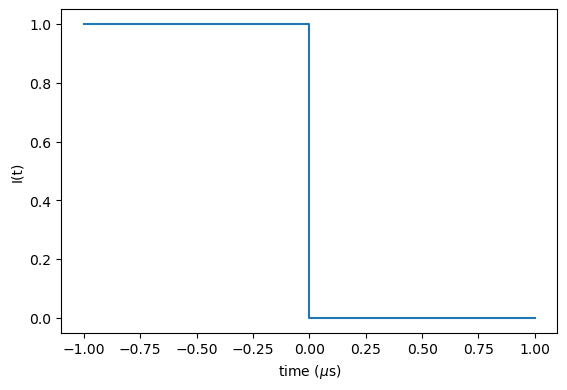

In [11]:
step_off.outputs[0]

#### But
* Turning off electrical current is like stopping a river's current
    * It's hard to do it fast
    * Requires a lot of control
* The larger the transmitter dipole moment, the harder it is to turn off.
* Like a wave crashing against a wall.

> Turning on electrical current is even harder

#### So what?
Usually have to "gently" shutoff the current

* For near-surface problems
    * Need high resolution at early times
    * Need rapid turn-off
    * Generally leads to small loops with low currents (~1-2 Amps)
* For deep exploration:
    * larger dipole moments are required
    * Slower turn-offs are ok.
    * Leads to large loops with high currents (~10-20 Amps)

#### Other waveforms:

In [12]:
%%capture ramp_off
ramp = tdem.sources.RampOffWaveform(2E-6)

ts = np.linspace(-1E-5, 1E-5, 256)
plt.plot(ts*1E6, [ramp.eval(t) for t in ts])
plt.xlabel(r'time ($\mu$s)');
plt.title("linear ramp-off")
plt.ylabel('I(t)')
plt.xlabel(r'time ($\mu$s)')
plt.show()

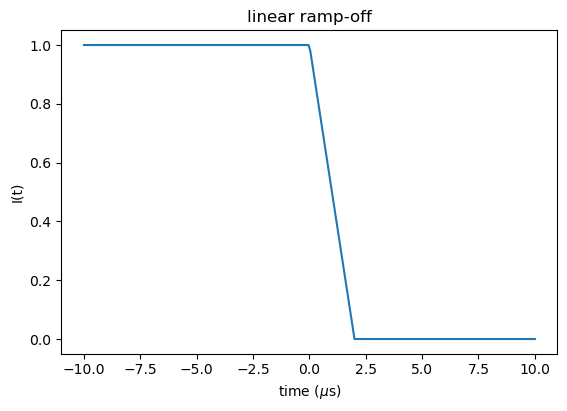

In [13]:
ramp_off.outputs[0]

In [14]:
%%capture quar_ramp
quar_sine_ramp = tdem.sources.QuarterSineRampOnWaveform((-1E-5, 0), (0, 1E-6))
plt.plot(ts*1E6, [quar_sine_ramp.eval(t) for t in ts])
plt.xlabel(r'time ($\mu$s)');
plt.title("Sine ramp on + linear ramp off")
plt.ylabel('I(t)')
plt.xlabel(r'time ($\mu$s)')
plt.show()

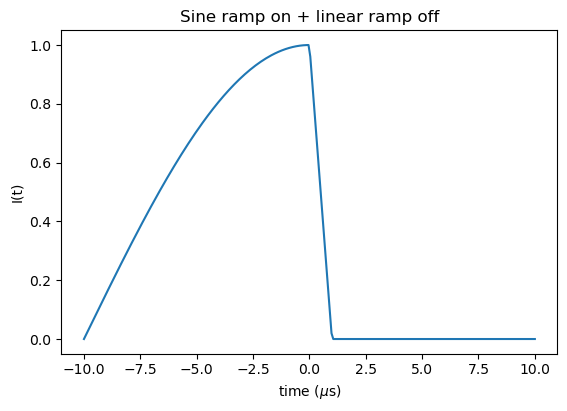

In [15]:
quar_ramp.outputs[0]

In [16]:
%%capture dual
plt.plot(
    [-5, -4, -4,-2, -2, 2, 2, 4, 4, 6],
    [0, 0, 1, 1,0, 0, 4, 4, 0, 0],
)
plt.title("Dual moment")
plt.ylabel('I(t)')
plt.xlabel(r'time ($\mu$s)')
plt.show()

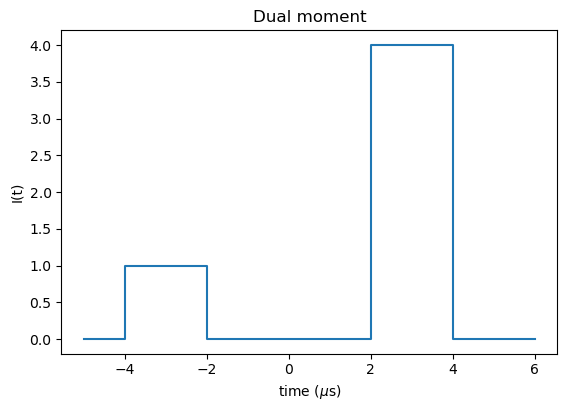

In [17]:
dual.outputs[0]

... and many more

## Receivers (Rx)
* Induction based coils - $\partial B/\partial T$
* Magnetic field sensors (new tech) $B$

### Induction recievers

<div class="row">
  <div class="column">

They measure the changing magnetic flux through a loop of wire.

Thus think Integral form of Faraday's law!

$$
\newcommand{\oiint}{{\subset\!\supset} \mathllap{\iint}}
V = EMF = -\oiint_A \frac{\partial \vec{B}}{\partial t} \cdot \vec{dA}
$$

</div>
<div class="column">


![Amperes](resources/1-faraday-flux.png "B field due to a wire")
</div>
</div>

<div class='row'>
<div class='column'>
        
* Some are rigid (e.g. Geonics EM-47 & ABEM WalkTEM)
* Some are not (e.g. ABEM WalkTEM, Zonge NanoTEM)
   * Setup like the transmitter coil!
</div>
<div class='column'>

![ProTEM](resources/2-protem.jpg "ProTEM HF3D Rx")
![WalkTEM](resources/2-walktem.png "WalkTEM rigid Rx") 
</div>
</div>

* How much signal is measured depends on
    * The transmitter (magnetic moment & waveform)
    * The earth conductivity (what we're interested in)
    * The coupling between the magnetic field and the receiver

#### Coupling

We essentially measure the change in magnetic flux perpendicular to our reciever loop.

> **Remember**
> we're integrating a dot product!
> $$
\newcommand{\oiint}{{\subset\!\supset} \mathllap{\iint}}
 -\oiint_A \frac{\partial \vec{B}}{\partial t} \cdot \vec{dA}
$$

A few cases:

**Well coupled**

<div class='row'>
<div class='column'>

* All field lines are ~perpendicular to the coil $\rightarrow$ Big EMF!
</div>
<div class='column'>

![good](resources/2-good-couple.png "good coupling")
</div>
</div>

**null coupled**
<div class='row'>
<div class='column'>

* All field lines are parallel to the coil $\rightarrow$ No EMF!
</div>
<div class='column'>

![null1](resources/2-null-couple.png "null coupling")</div>
</div>

**null coupled**

<div class='row'>
<div class='column'>

* Field lines go both into and out of the coil $\rightarrow$ No EMF
</div>
<div class='column'>

![null1](resources/2-null-couple2.png "null coupling")
</div>
</div>

### Recording Electrical Signals

Important to have at least a basic understanding of how electrical signals are recorded so you can understand the options presented by instruments and what you can to expect them to do.

* A voltage is induced in the coil.
* It gets "boosted".
* It gets converted from an analogue signal to a digital signal.
* The digital signal is saved at specific times.

#### ADC (Analog to digital converter)

* Signals we measure are continuous in both time **and** amplitude.
* The incoming analog signal's amplitude get's quantized (discretize) into discrete numbers.
    * Basically rounding the amplitude
* They often have a certain number of channels (Think bits in a floating point number).


> relevant wikipedia page: https://en.wikipedia.org/wiki/Analog-to-digital_converter

> Digital Signal Analysis will give you tons of information about sampling an analog signal

In [18]:
def continuous_func(x):
    return 2*np.sin(x)**3  + np.cos(x)**2

In [19]:
%%capture img1
plt.figure(dpi=300)
x = np.linspace(-2*np.pi, 2*np.pi, num=1024)
plt.plot(x, continuous_func(x), label='analogue signal')
plt.legend()
plt.xlabel('time')
plt.ylabel('voltage')
plt.show()

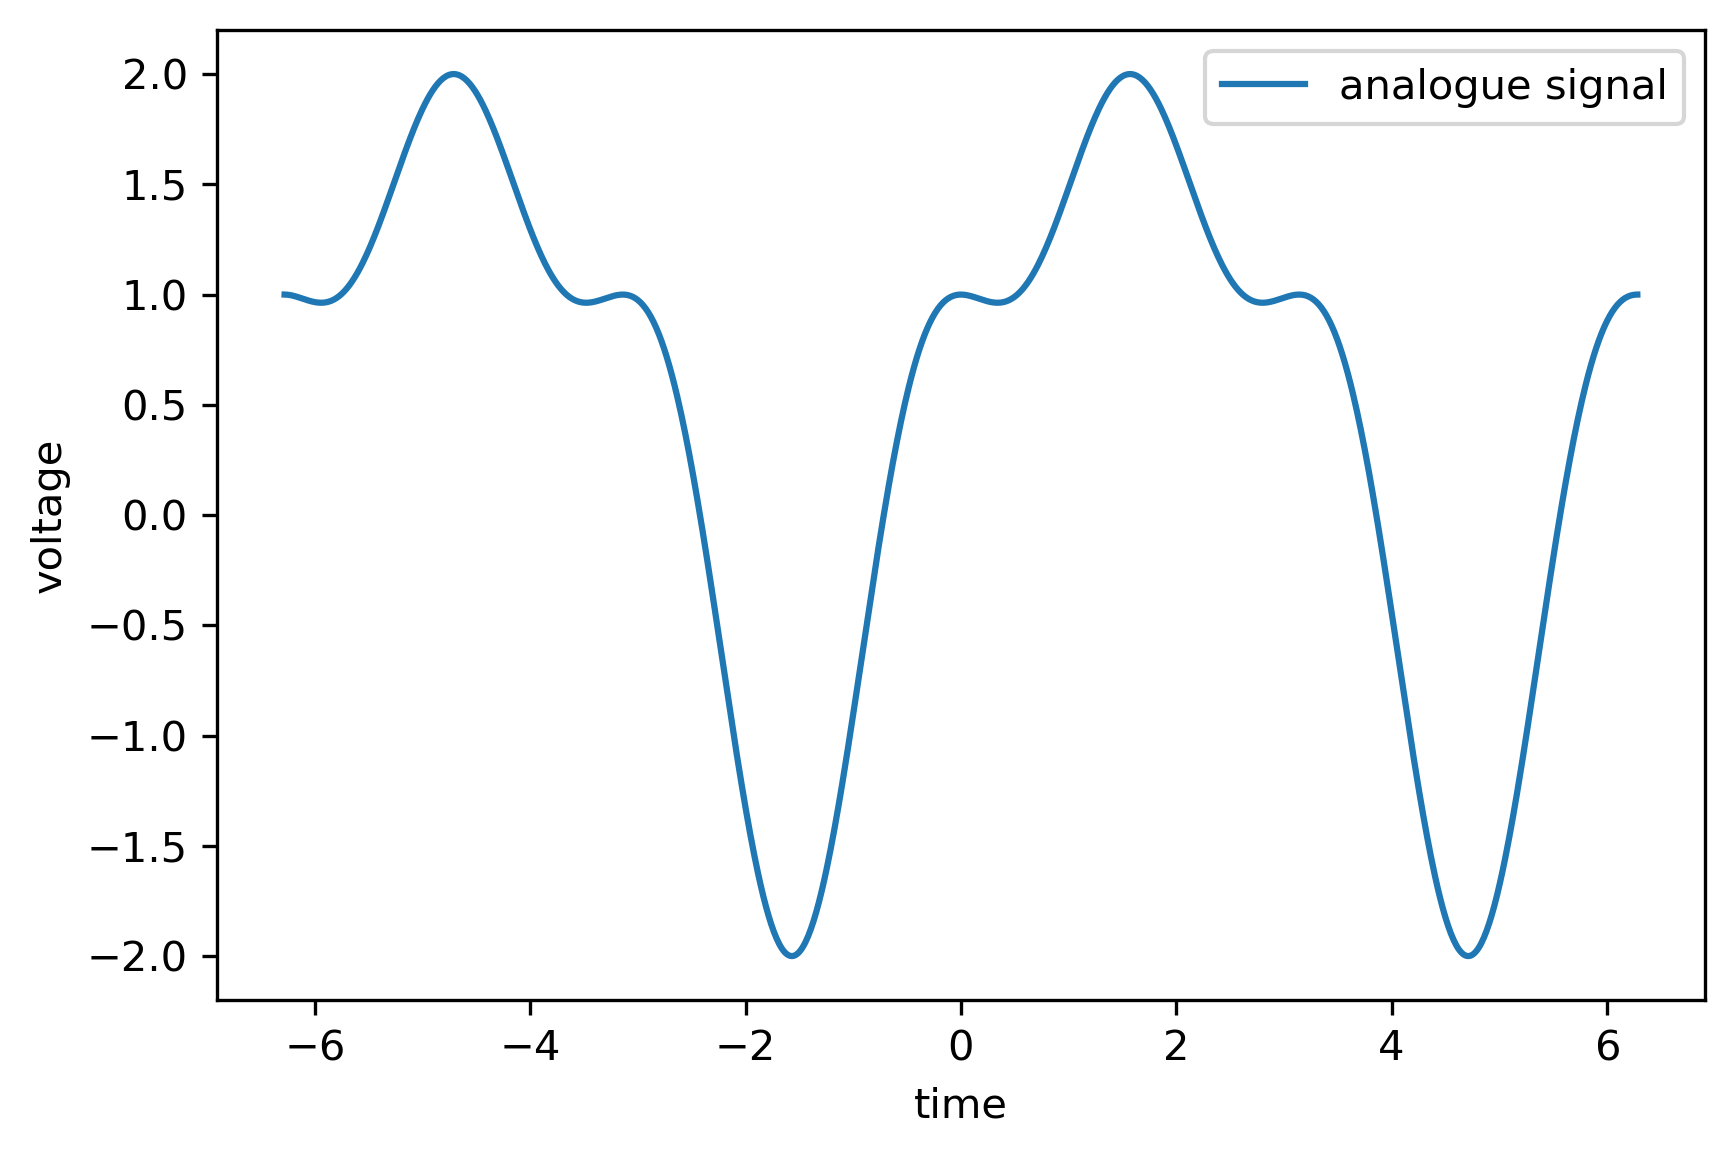

In [20]:
img1.outputs[0]

In [21]:
adc_channels = np.r_[-1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

In [22]:
%%capture img2
fig = plt.figure(dpi=300)
ana = plt.plot(x, continuous_func(x), label='analogue signal')
lines = [plt.axhline(level, color='C1') for level in adc_channels]
lines[0].set_label('ADC channels')
plt.legend()
plt.xlabel('time')
plt.ylabel('voltage')
plt.show()

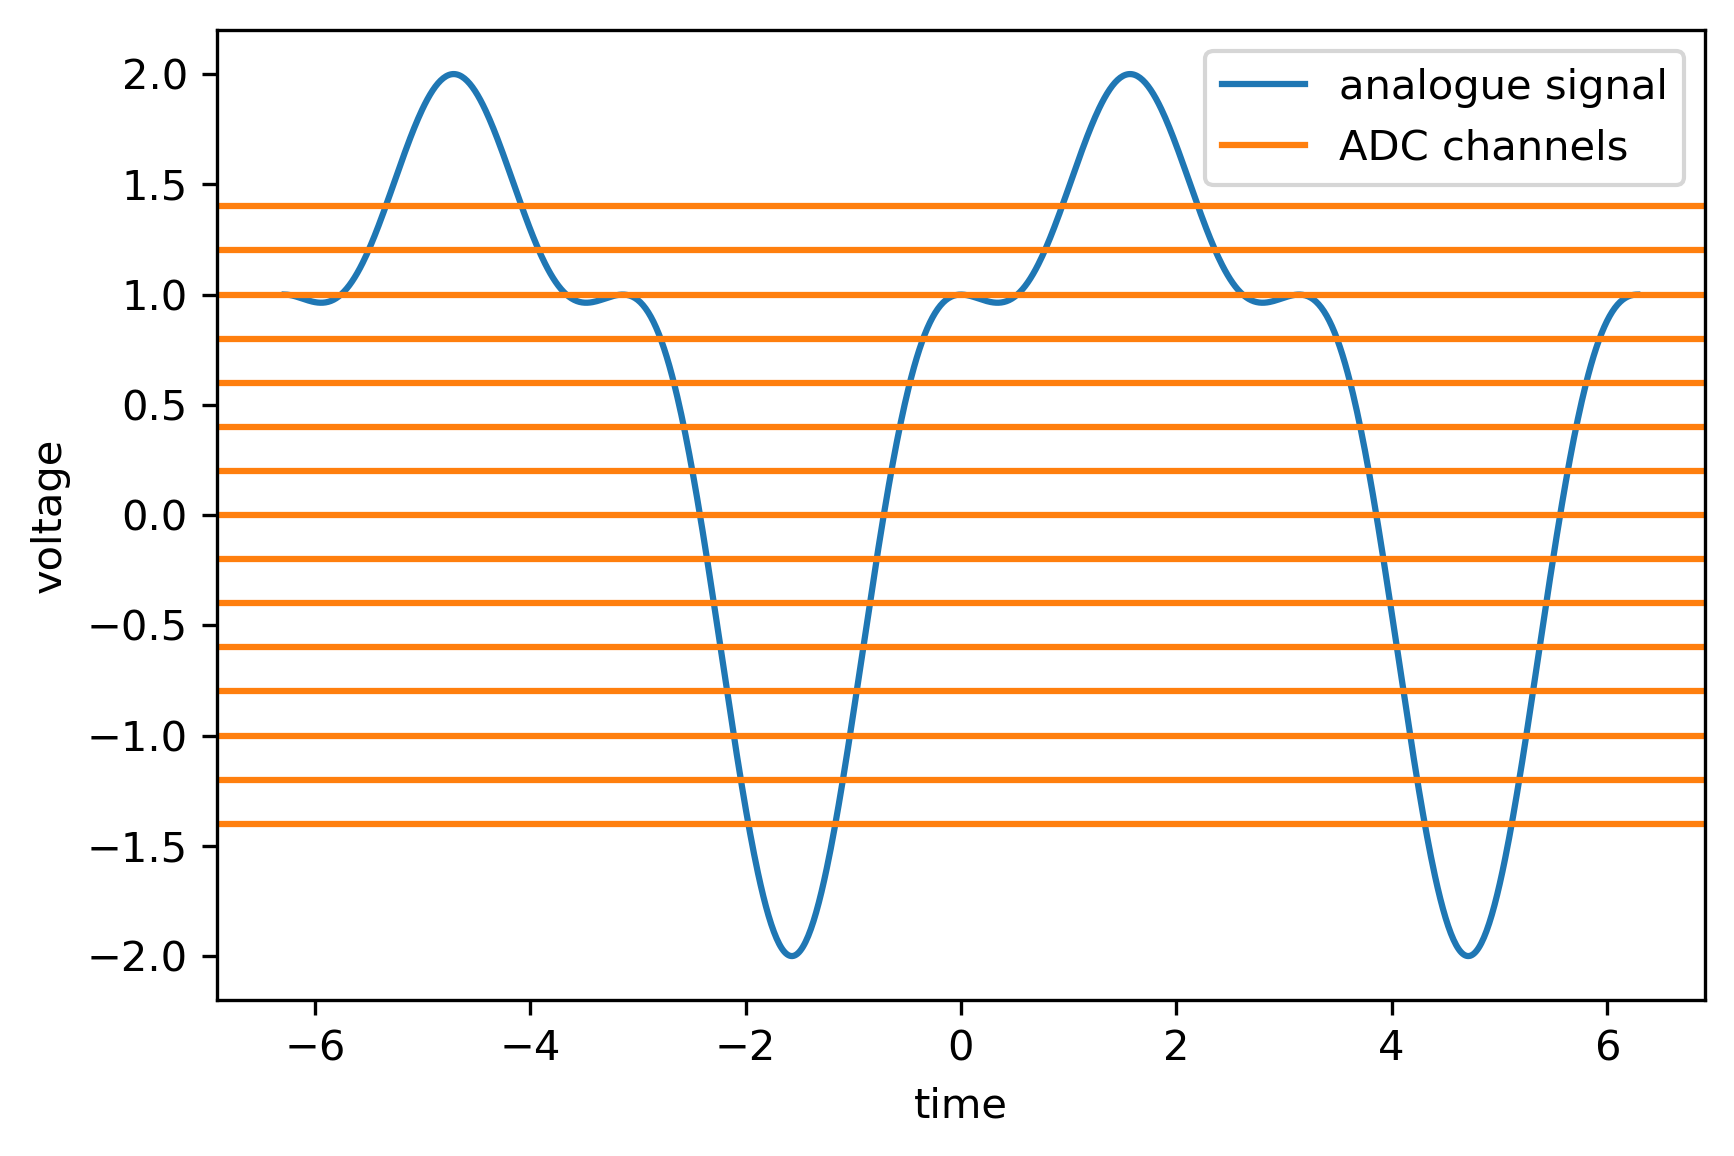

In [23]:
img2.outputs[0]

In [24]:
def ADC_convert(signal, channels):
    bins = np.digitize(signal, channels)
    bins = np.minimum(len(channels)-1, bins)
    return channels[bins]

In [25]:
%%capture img3
plt.figure(dpi=300)
ana = plt.plot(x, continuous_func(x), label='analogue signal')
lines = [plt.axhline(level, color='C1', alpha=0.4) for level in adc_channels]
lines[0].set_label('ADC bins')
quant = plt.plot(x, ADC_convert(continuous_func(x), adc_channels), color='C2', label='quantized signal')
plt.legend()
plt.xlabel('time')
plt.ylabel('voltage')
plt.show()

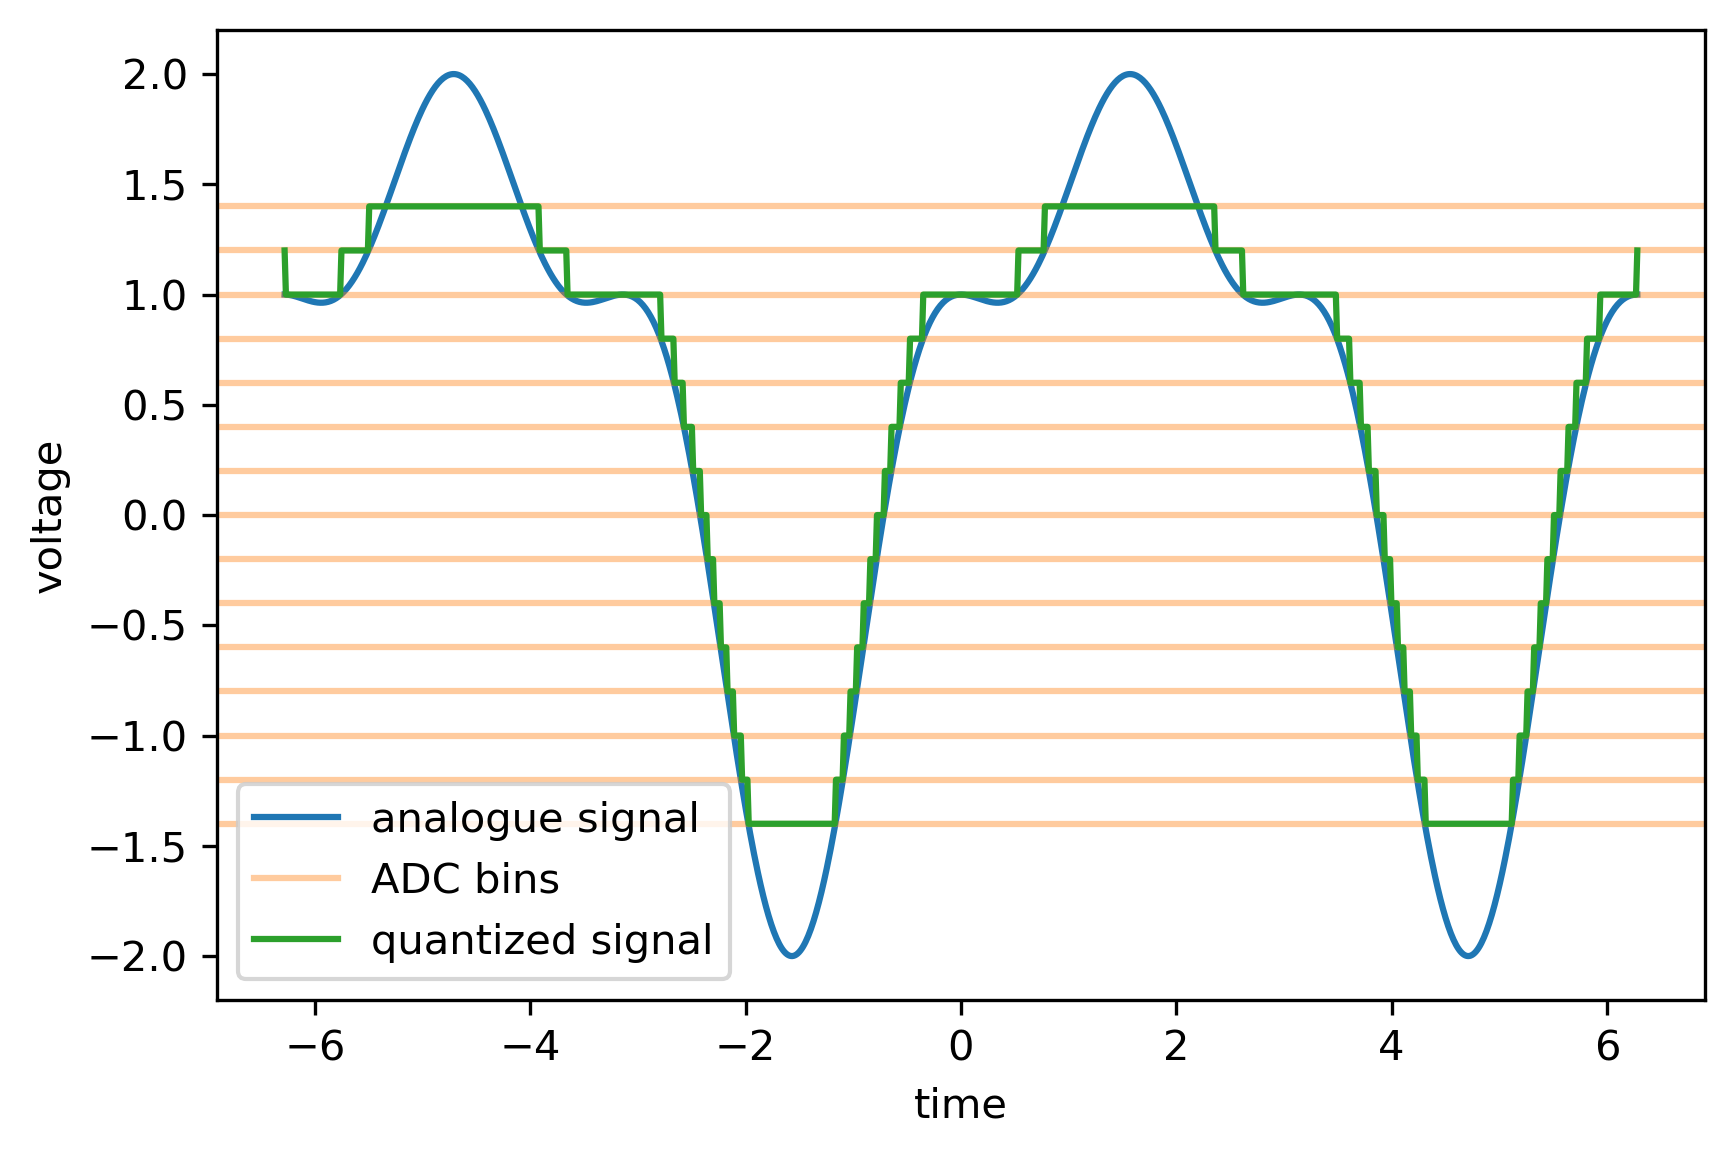

In [26]:
img3.outputs[0]

Important concepts
* ADC has only a set number of values it can output
* For best resolution and accuracy, we want to use a majority of the bins but...
* Any signal outside those bins gets clipped

#### Gain

<div class='row'>
    <div class='column'>

Before the analogue signal gets converted to a digital signal we can boost it.
        
* Another electrical circuit component
* Usually gains are powers of 2
* Analogue input gets multiplied by a constant factor
    * input is signal and noise!

    </div>
    <div class='column'>

|gain| factor|
|----|-------|
| 0 |  $2^0=1$ |
| 1 | $2^1 = 2$ |
| 2 | $2^3 = 4$ |
| $\vdots$ | $\vdots$ |
| n | $2^n$|

</div>
</div>

Choosing a gain:

* Essentially boost the signal as much as possible **before** ADC
* but **can't** boost too much (don't want to go beyond the ADC's bins)
* So start with a high boost then decrease it
    * It's obvious when it hits the rails

### Time gates

* Recievers integrate the voltage before ADC as well
* Easier to measure an integrated voltage than a single voltage
* Leads to the concept of "Time Gates" in TDEM
